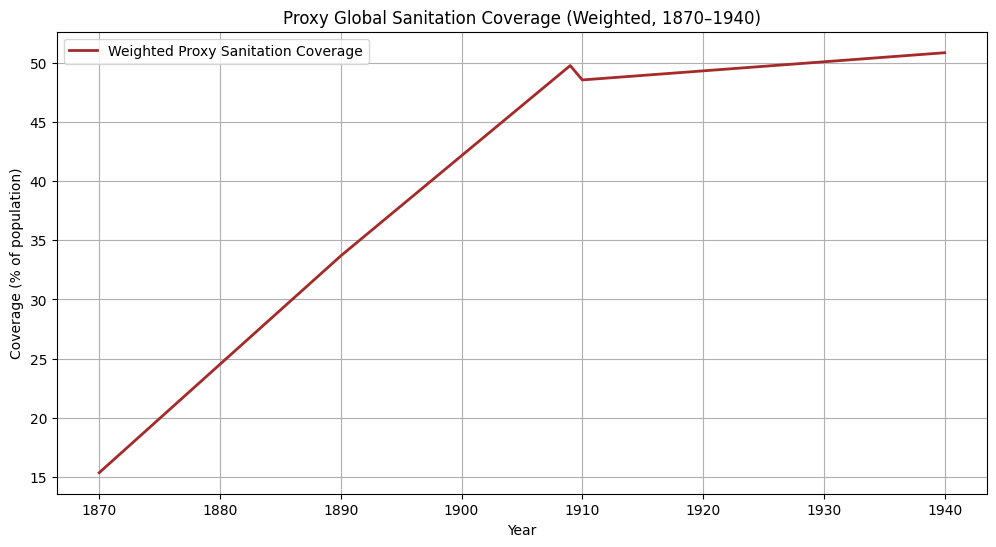

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- Step 1. Input sanitation data ----
data = {
    "City":["Helsinki","Helsinki","Helsinki","Helsinki",
            "Sydney","Sydney","Sydney","Sydney",
            "Calcutta","Calcutta","Calcutta",
            "Bogotá","Bogotá"],
    "Country":["Finland"]*4 + ["Australia"]*4 + ["India"]*3 + ["Colombia"]*2,
    "Year":[1870,1890,1910,1940, 1870,1890,1910,1940, 1870,1910,1940, 1910,1940],
    "WaterCoverage":[0.5,26,61,85, 60,80,100,None, 14,50,59, 30,59],
    "SewerageCoverage":[None,None,32,68, None,None,None,80, None,37,14, None,14]
}

df = pd.DataFrame(data)

# ---- Step 2. Sanitation index (average of water + sewerage when both exist) ----
df["SanitationIndex"] = df[["WaterCoverage","SewerageCoverage"]].mean(axis=1, skipna=True)

# ---- Step 3. Assign weights (proxy populations circa 1900) ----
weights = {
    "India":0.55,
    "Finland":0.25,   # proxy for Europe
    "Colombia":0.10,  # Latin America
    "Australia":0.10  # Oceania
}
df["Weight"] = df["Country"].map(weights)

# ---- Step 4. Build weighted proxy curve ----
years = range(1870, 1941)
records = []

for year in years:
    weighted_sum = 0
    total_weight = 0
    for country in df["Country"].unique():
        subset = df[df["Country"] == country][["Year","SanitationIndex"]].dropna()
        if year < subset["Year"].min() or year > subset["Year"].max():
            continue
        # interpolate within each country
        interp = subset.set_index("Year").reindex(range(subset["Year"].min(), subset["Year"].max()+1))
        interp["SanitationIndex"] = interp["SanitationIndex"].interpolate()
        val = interp.loc[year,"SanitationIndex"]
        weighted_sum += val * weights[country]
        total_weight += weights[country]
    if total_weight > 0:
        records.append({"Year":year, "ProxySanitation":weighted_sum / total_weight})

proxy_df = pd.DataFrame(records)

# ---- Step 5. Plot ----
plt.figure(figsize=(12,6))
plt.plot(proxy_df["Year"], proxy_df["ProxySanitation"], color="brown", linewidth=2, label="Weighted Proxy Sanitation Coverage")
plt.title("Proxy Global Sanitation Coverage (Weighted, 1870–1940)")
plt.xlabel("Year")
plt.ylabel("Coverage (% of population)")
plt.grid(True)
plt.legend()
plt.show()




In [10]:
import pandas as pd
from pathlib import Path

# === Config ===
PATH = "../data/worldbank_sanitation.csv"

# Choose ONE of these (must match EXACT text in your CSV)
INDICATOR = "People using safely managed drinking water services (% of population)"
# INDICATOR = "People using safely managed sanitation services (% of population)"


def load_worldbank_csv(path: str | Path) -> pd.DataFrame:
    """
    Loads a World Bank WDI-style CSV that contains 2 metadata lines and blank lines
    before the actual header. Also removes unnamed columns and trims column names.
    """
    df = pd.read_csv(path, skiprows=4, low_memory=False)
    # Drop stray 'Unnamed' columns caused by trailing commas
    df = df.loc[:, ~df.columns.str.contains(r"^Unnamed")]
    # Normalize column names
    df.columns = df.columns.str.strip()
    return df


def ensure_indicator_present(df: pd.DataFrame, indicator: str) -> None:
    if "Indicator Name" not in df.columns:
        raise ValueError("CSV seems malformed: missing 'Indicator Name' column.")
    if indicator not in set(df["Indicator Name"].dropna().unique()):
        # Help the user by showing a few available indicator names
        avail = sorted(set(df["Indicator Name"].dropna().unique()))
        preview = "\n  - " + "\n  - ".join(avail[:10])
        raise ValueError(
            f"Indicator not found:\n  {indicator}\n\n"
            f"Here are a few indicators present in this file (first 10):{preview}\n"
            f"If you're using the drinking water file, pick the water string; "
            f"if it's the sanitation file, pick the sanitation string."
        )


def melt_years(df: pd.DataFrame, id_cols=("Country Name",)) -> pd.DataFrame:
    """Melt wide year columns (1960..2100 etc.) into long format."""
    year_cols = [c for c in df.columns if c.isdigit()]
    if not year_cols:
        raise ValueError("No year columns detected (e.g., '1960', '1961', ...).")
    long_df = df.melt(
        id_vars=list(id_cols),
        value_vars=year_cols,
        var_name="Year",
        value_name="Coverage",
    )
    # Convert types
    long_df["Year"] = pd.to_numeric(long_df["Year"], errors="coerce")
    long_df["Coverage"] = pd.to_numeric(long_df["Coverage"], errors="coerce")
    return long_df


def get_world_series(df: pd.DataFrame, indicator: str) -> pd.DataFrame:
    """
    Filter to the chosen indicator and the 'World' aggregate row (if present),
    then return a long DataFrame with columns: Country Name, Year, Coverage.
    """
    sub = df[df["Indicator Name"] == indicator].copy()
    if sub.empty:
        raise ValueError("No rows for the selected indicator after filtering.")

    if "Country Name" not in sub.columns:
        raise ValueError("CSV seems malformed: missing 'Country Name' column.")

    # Try to find the 'World' aggregate
    world = sub[sub["Country Name"] == "World"].copy()
    if world.empty:
        raise ValueError(
            "No 'World' aggregate row found in this file for the chosen indicator.\n"
            "If needed, we can compute a global series from countries, but that "
            "requires country populations per year."
        )

    # Drop metadata columns we don't need
    world = world.drop(columns=["Country Code", "Indicator Name", "Indicator Code"], errors="ignore")
    world_long = melt_years(world, id_cols=("Country Name",))
    return world_long


# === Run ===
wb_df = load_worldbank_csv(PATH)
ensure_indicator_present(wb_df, INDICATOR)
world_long = get_world_series(wb_df, INDICATOR)

# Clean up: drop NaNs and keep only years >= 2000
world_long = world_long.dropna(subset=["Coverage"])
world_long = world_long[world_long["Year"] >= 2000].reset_index(drop=True)

print(world_long.head(10))
print("\nRows:", len(world_long))


  Country Name  Year   Coverage
0        World  2000  60.816218
1        World  2001  61.130202
2        World  2002  61.798282
3        World  2003  62.363246
4        World  2004  62.965596
5        World  2005  63.655816
6        World  2006  63.952691
7        World  2007  64.634000
8        World  2008  64.879711
9        World  2009  65.397381

Rows: 23


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
life_path = "../data/life-expectancy.csv"
vacc_path = "../data/Diphtheria tetanus toxoid and pertussis (DTP) vaccination coverage.csv"

life_df = pd.read_csv(life_path)
vacc_df = pd.read_csv(vacc_path)

# Keep only World
world_life = life_df[life_df["Entity"] == "World"][["Year", "Period life expectancy at birth"]]
world_life.columns = ["Year", "LifeExpectancy"]

global_vacc = vacc_df[vacc_df["GROUP"] == "GLOBAL"][["YEAR", "COVERAGE"]]
global_vacc.columns = ["Year", "Coverage"]


/tmp/ipykernel_8296/2726108347.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sanitation_full["Sanitation"] = sanitation_full["Sanitation"].fillna(method="ffill").fillna(method="bfill")


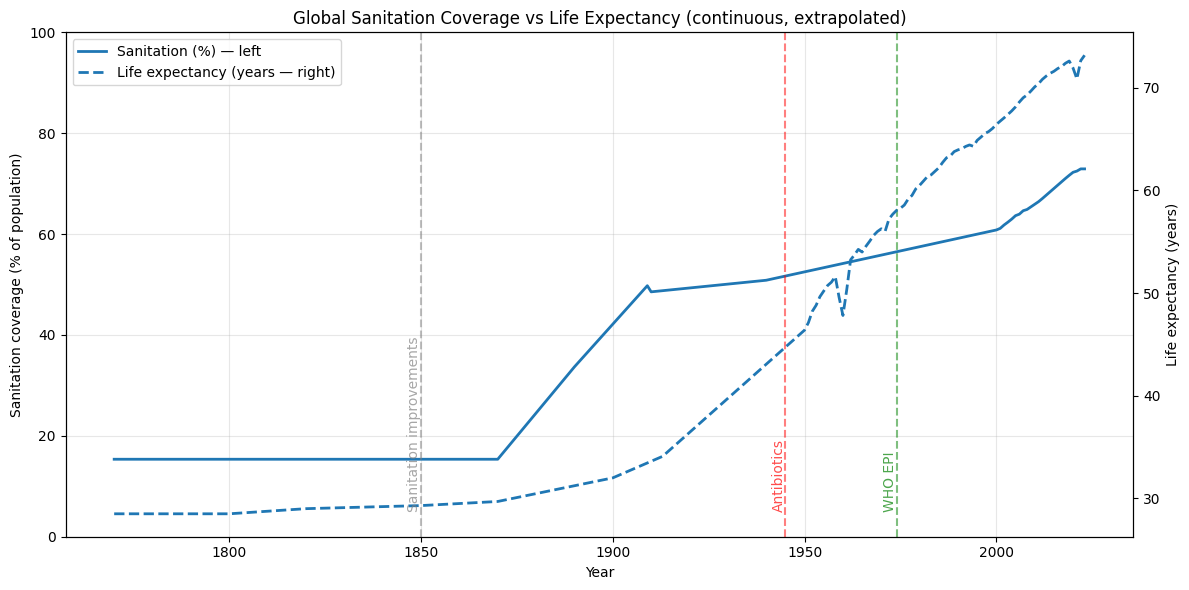

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Sanitation proxy (1870–1940) ---
san_proxy = proxy_df[["Year","ProxySanitation"]].copy()
san_proxy.columns = ["Year","Sanitation"]
san_proxy = san_proxy.dropna()

# --- Modern sanitation (2000–present, World aggregate) ---
san_modern = world_long.copy()
if "Country Name" in san_modern.columns:
    san_modern = san_modern[san_modern["Country Name"]=="World"]
san_modern = san_modern[["Year","Coverage"]].copy()
san_modern.columns = ["Year","Sanitation"]
san_modern = san_modern.dropna()

# --- Combine and interpolate/extrapolate ---
sanitation = pd.concat([san_proxy, san_modern], ignore_index=True).dropna()
sanitation = sanitation.drop_duplicates("Year").sort_values("Year")

# Reindex over full LE range (e.g. 1770–2023)
year_min = int(world_life["Year"].min())
year_max = int(world_life["Year"].max())
full_years = pd.DataFrame({"Year": range(year_min, year_max+1)})

sanitation_full = full_years.merge(sanitation, on="Year", how="left")

# Interpolate inside known ranges
sanitation_full["Sanitation"] = sanitation_full["Sanitation"].interpolate()

# Extrapolate: forward/backfill edges
sanitation_full["Sanitation"] = sanitation_full["Sanitation"].fillna(method="ffill").fillna(method="bfill")

# Clamp to 0–100%
sanitation_full["Sanitation"] = sanitation_full["Sanitation"].clip(0,100)

# --- Life expectancy (continuous, no merge) ---
le = world_life[["Year","LifeExpectancy"]].copy()
le = le.dropna().sort_values("Year")

# --- Plot: Sanitation vs Life Expectancy ---
fig, ax1 = plt.subplots(figsize=(12,6))

l_san = ax1.plot(sanitation_full["Year"], sanitation_full["Sanitation"], lw=2, label="Sanitation coverage (%)")
ax1.set_ylim(0,100)
ax1.set_xlabel("Year")
ax1.set_ylabel("Sanitation coverage (% of population)")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
l_le = ax2.plot(le["Year"], le["LifeExpectancy"], lw=2, ls="--", label="Life expectancy (years)")
ax2.set_ylabel("Life expectancy (years)")

# Milestones
for x, color, txt in [
    (1850,"gray","Sanitation improvements"),
    (1945,"red","Antibiotics"),
    (1974,"green","WHO EPI"),
]:
    ax1.axvline(x, color=color, linestyle="--", alpha=0.5)
    ymin,ymax = ax2.get_ylim()
    ax2.text(x, ymin + 0.05*(ymax-ymin), txt, rotation=90,
             va="bottom", ha="right", color=color, alpha=0.7)

# Legend
handles = [
    Line2D([], [], lw=2, color=l_san[0].get_color(), label="Sanitation (%) — left"),
    Line2D([], [], lw=2, ls="--", color=l_le[0].get_color(), label="Life expectancy (years — right)"),
]
ax1.legend(handles=handles, loc="upper left")

plt.title("Global Sanitation Coverage vs Life Expectancy (continuous, extrapolated)")
plt.tight_layout()
plt.show()





Pearson correlation (overlapping years = 23): r = 1.000


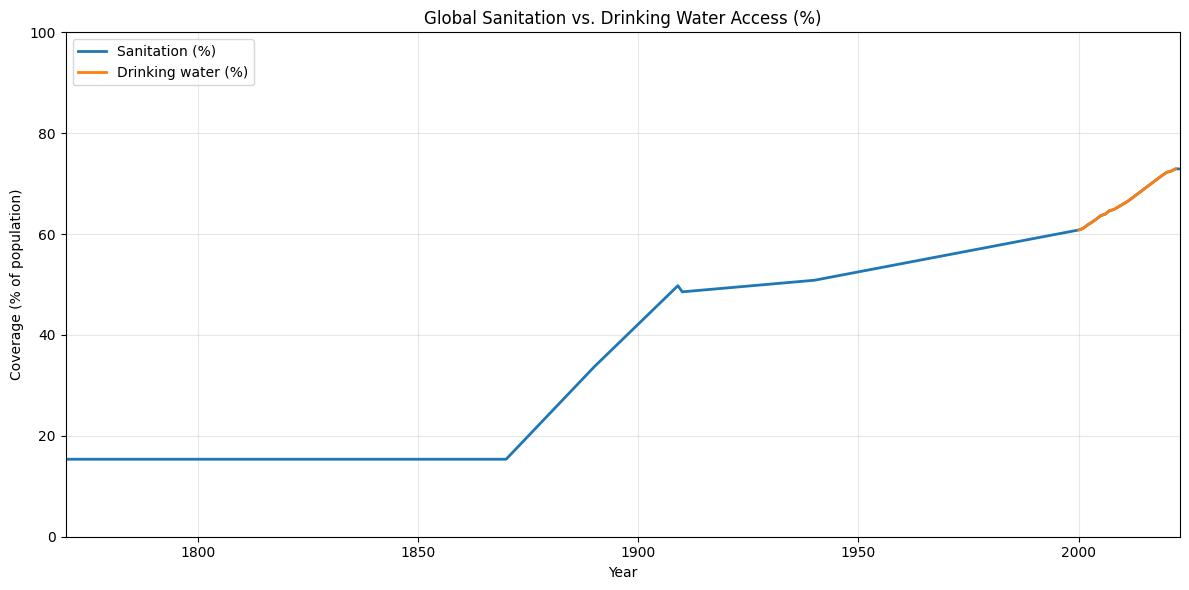

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Expect these to exist from your previous steps ---
# sanitation_full: DataFrame with columns ["Year", "Sanitation"]  (continuous 0–100)
# world_long     : DataFrame with World water access -> columns ["Country Name","Year","Coverage"]

# 1) Prepare the water series (World only)
water = world_long.copy()
if "Country Name" in water.columns:
    water = water[water["Country Name"] == "World"]
water = water[["Year","Coverage"]].rename(columns={"Coverage":"Water"}).copy()
water["Year"] = pd.to_numeric(water["Year"], errors="coerce")
water["Water"] = pd.to_numeric(water["Water"], errors="coerce")

# 2) Prepare the sanitation series
san = sanitation_full[["Year","Sanitation"]].copy()
san["Year"] = pd.to_numeric(san["Year"], errors="coerce")
san["Sanitation"] = pd.to_numeric(san["Sanitation"], errors="coerce")

# 3) Merge on Year to align for plotting & correlation
merged = (san.merge(water, on="Year", how="outer")
             .sort_values("Year").reset_index(drop=True))

# Clamp to 0–100 just in case
for col in ["Sanitation","Water"]:
    merged[col] = merged[col].clip(0, 100)

# 4) Compute correlation on the overlapping years
overlap = merged.dropna(subset=["Sanitation","Water"])
corr = overlap["Sanitation"].corr(overlap["Water"])
print(f"Pearson correlation (overlapping years = {len(overlap)}): r = {corr:.3f}")

# 5) Plot both series on one axis
plt.figure(figsize=(12,6))
plt.plot(merged["Year"], merged["Sanitation"], linewidth=2, label="Sanitation (%)")
plt.plot(merged["Year"], merged["Water"], linewidth=2, label="Drinking water (%)")

plt.ylim(0, 100)
plt.xlim(int(np.nanmin(merged["Year"])), int(np.nanmax(merged["Year"])))
plt.xlabel("Year")
plt.ylabel("Coverage (% of population)")
plt.title("Global Sanitation vs. Drinking Water Access (%)")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# Optional: save
# plt.savefig("../data/sanitation_vs_water_overlay.png", dpi=150, bbox_inches="tight")


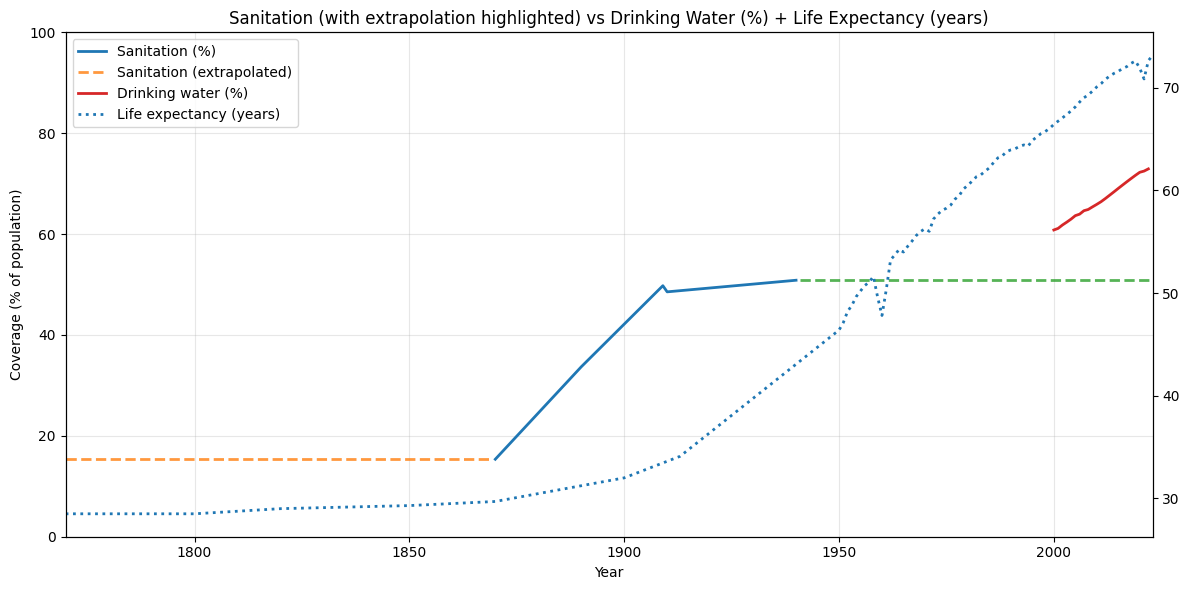

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# -------- 1) Build sanitation curve with extrapolation flagged --------
# Observed sanitation points come from your proxy (1870–1940).
san_obs = proxy_df[["Year","ProxySanitation"]].copy()
san_obs.columns = ["Year","Sanitation"]
san_obs["Year"] = pd.to_numeric(san_obs["Year"], errors="coerce")
san_obs["Sanitation"] = pd.to_numeric(san_obs["Sanitation"], errors="coerce")
san_obs = san_obs.dropna().drop_duplicates(subset=["Year"]).sort_values("Year")

# If you ALSO have a modern sanitation World series, you can append it here:
# modern = world_sanitation_long[["Year","Coverage"]].rename(columns={"Coverage":"Sanitation"})
# modern["Year"] = pd.to_numeric(modern["Year"], errors="coerce")
# modern["Sanitation"] = pd.to_numeric(modern["Sanitation"], errors="coerce")
# san_obs = pd.concat([san_obs, modern], ignore_index=True).dropna().drop_duplicates("Year").sort_values("Year")

if san_obs.empty:
    raise ValueError("No observed sanitation points found in proxy_df.")

obs_min, obs_max = int(san_obs["Year"].min()), int(san_obs["Year"].max())
first_val = float(san_obs.loc[san_obs["Year"] == obs_min, "Sanitation"].iloc[0])
last_val  = float(san_obs.loc[san_obs["Year"] == obs_max, "Sanitation"].iloc[0])

# Make a continuous year index spanning life expectancy range
le = world_life[["Year","LifeExpectancy"]].copy()
le["Year"] = pd.to_numeric(le["Year"], errors="coerce")
le["LifeExpectancy"] = pd.to_numeric(le["LifeExpectancy"], errors="coerce")
le = le.dropna().sort_values("Year")
year_min, year_max = int(le["Year"].min()), int(le["Year"].max())

san_full = pd.DataFrame({"Year": np.arange(year_min, year_max + 1)})
san_full = san_full.merge(san_obs[["Year","Sanitation"]], on="Year", how="left")

# Interpolate ONLY inside the observed span
san_full["Sanitation_interp"] = san_full["Sanitation"]
mask_mid = (san_full["Year"] >= obs_min) & (san_full["Year"] <= obs_max)
san_full.loc[mask_mid, "Sanitation_interp"] = (
    san_full.loc[mask_mid, "Sanitation_interp"].interpolate()
)

# Build three segments: early (extrapolated), mid (observed/interpolated), late (extrapolated)
early = san_full[san_full["Year"] < obs_min].copy()
mid   = san_full[mask_mid].copy()
late  = san_full[san_full["Year"] > obs_max].copy()

early["Sanitation_plot"] = first_val       # flat extrapolation before obs_min
mid["Sanitation_plot"]   = mid["Sanitation_interp"]  # interpolated within observed range
late["Sanitation_plot"]  = last_val        # flat extrapolation after obs_max

# Clamp to [0,100]
for _df in (early, mid, late):
    _df["Sanitation_plot"] = _df["Sanitation_plot"].clip(0, 100)

# -------- 2) Drinking water (World, %) --------
water = world_long.copy()
if "Country Name" in water.columns:
    water = water[water["Country Name"] == "World"]
water = water[["Year","Coverage"]].rename(columns={"Coverage":"Water"}).copy()
water["Year"] = pd.to_numeric(water["Year"], errors="coerce")
water["Water"] = pd.to_numeric(water["Water"], errors="coerce")
water = water.dropna().sort_values("Year")
water["Water"] = water["Water"].clip(0, 100)

# -------- 3) Plot: sanitation with extrap segments styled, water solid, LE on right axis --------
fig, ax1 = plt.subplots(figsize=(12,6))

# Sanitation: plot mid (solid), early/late (dashed)
l_san_mid,  = ax1.plot(mid["Year"],   mid["Sanitation_plot"],  lw=2, label="Sanitation (%)")
l_san_early,= ax1.plot(early["Year"], early["Sanitation_plot"], lw=2, ls="--", alpha=0.8, label="Sanitation (extrapolated)")
l_san_late, = ax1.plot(late["Year"],  late["Sanitation_plot"],  lw=2, ls="--", alpha=0.8)

# Water: single solid line
l_wat, = ax1.plot(water["Year"], water["Water"], lw=2, label="Drinking water (%)")

ax1.set_ylim(0, 100)
xmin = int(min(early["Year"].min() if not early.empty else obs_min, water["Year"].min() if not water.empty else obs_min, le["Year"].min()))
xmax = int(max(late["Year"].max()  if not late.empty  else obs_max, water["Year"].max() if not water.empty else obs_max, le["Year"].max()))
ax1.set_xlim(xmin, xmax)
ax1.set_xlabel("Year")
ax1.set_ylabel("Coverage (% of population)")
ax1.grid(True, alpha=0.3)

# Life expectancy on right axis (no merging, so no gaps)
l_le, = ax1.twinx().plot(le["Year"], le["LifeExpectancy"], lw=2, ls=":", label="Life expectancy (years)")
ax1.get_shared_x_axes()

# Legend (combine)
handles = [
    Line2D([], [], lw=2, color=l_san_mid.get_color(), label="Sanitation (%)"),
    Line2D([], [], lw=2, ls="--", alpha=0.8, color=l_san_early.get_color(), label="Sanitation (extrapolated)"),
    Line2D([], [], lw=2, color=l_wat.get_color(), label="Drinking water (%)"),
    Line2D([], [], lw=2, ls=":", color=l_le.get_color(), label="Life expectancy (years)"),
]
ax1.legend(handles=handles, loc="upper left")

plt.title("Sanitation (with extrapolation highlighted) vs Drinking Water (%) + Life Expectancy (years)")
plt.tight_layout()
plt.show()

# Optional: save
# fig.savefig("../data/sanitation_water_le_overlay_extrap_highlighted.png", dpi=150, bbox_inches="tight")


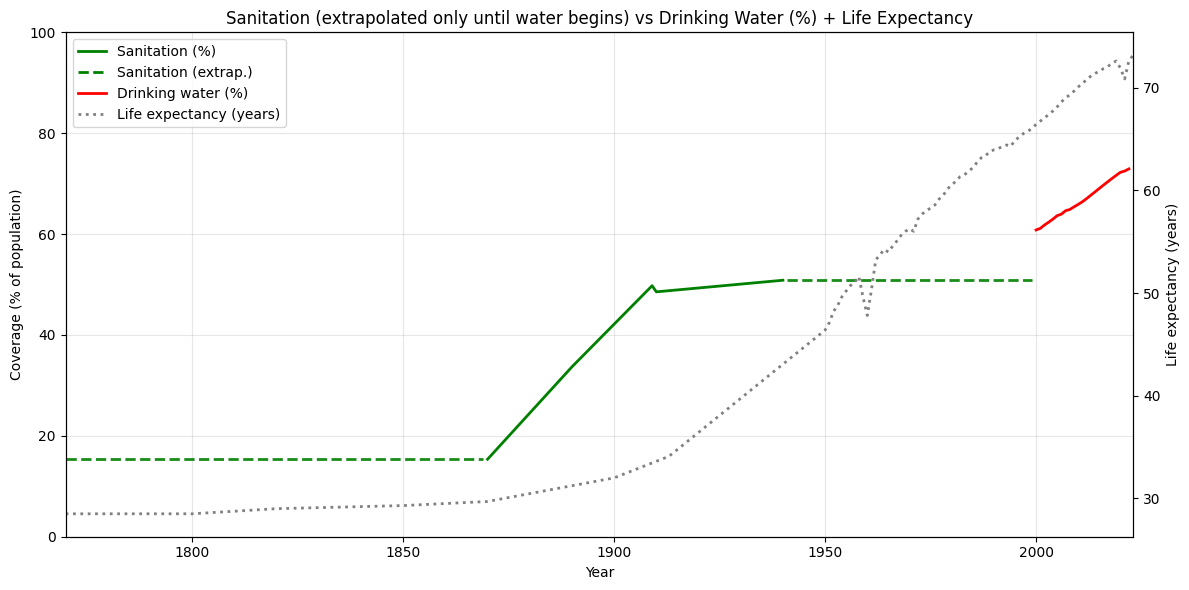

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ------- Inputs expected -------
# proxy_df: ["Year","ProxySanitation"]  (observed proxy 1870–1940, etc.)
# world_long: World drinking water (%): ["Country Name","Year","Coverage"]
# world_life: ["Year","LifeExpectancy"]

# --- Observed sanitation points
san_obs = proxy_df[["Year","ProxySanitation"]].rename(columns={"ProxySanitation":"Sanitation"}).copy()
san_obs["Year"] = pd.to_numeric(san_obs["Year"], errors="coerce")
san_obs["Sanitation"] = pd.to_numeric(san_obs["Sanitation"], errors="coerce")
san_obs = san_obs.dropna().drop_duplicates("Year").sort_values("Year")
if san_obs.empty:
    raise ValueError("No observed sanitation points found in proxy_df.")

obs_min, obs_max = int(san_obs["Year"].min()), int(san_obs["Year"].max())
first_val = float(san_obs.loc[san_obs["Year"] == obs_min, "Sanitation"].iloc[0])
last_val  = float(san_obs.loc[san_obs["Year"] == obs_max, "Sanitation"].iloc[0])

# --- Life expectancy (for span)
le = world_life[["Year","LifeExpectancy"]].copy()
le["Year"] = pd.to_numeric(le["Year"], errors="coerce")
le["LifeExpectancy"] = pd.to_numeric(le["LifeExpectancy"], errors="coerce")
le = le.dropna().sort_values("Year")
year_min, year_max = int(le["Year"].min()), int(le["Year"].max())

# --- Drinking water (World, %)
water = world_long.copy()
if "Country Name" in water.columns:
    water = water[water["Country Name"] == "World"]
water = water[["Year","Coverage"]].rename(columns={"Coverage":"Water"}).copy()
water["Year"] = pd.to_numeric(water["Year"], errors="coerce")
water["Water"] = pd.to_numeric(water["Water"], errors="coerce")
water = water.dropna().sort_values("Year")
water["Water"] = water["Water"].clip(0, 100)
water_min = int(water["Year"].min()) if not water.empty else None

# --- Build sanitation continuous index for plotting
san_full = pd.DataFrame({"Year": np.arange(year_min, year_max + 1)})
san_full = san_full.merge(san_obs[["Year","Sanitation"]], on="Year", how="left")

# Interpolate ONLY inside [obs_min, obs_max]
mask_mid = (san_full["Year"] >= obs_min) & (san_full["Year"] <= obs_max)
san_full["Sanitation_interp"] = san_full["Sanitation"]
san_full.loc[mask_mid, "Sanitation_interp"] = san_full.loc[mask_mid, "Sanitation_interp"].interpolate()

# Segments
early = san_full[san_full["Year"] < obs_min].copy()
mid   = san_full[mask_mid].copy()
late  = san_full[san_full["Year"] > obs_max].copy()

# Clip late segment to stop BEFORE water starts (so water “takes over”)
if water_min is not None:
    late = late[late["Year"] < water_min]

# Assign plotting values: flat extrapolation outside observed span
early["Sanitation_plot"] = first_val
mid["Sanitation_plot"]   = mid["Sanitation_interp"]
late["Sanitation_plot"]  = last_val

for _df in (early, mid, late):
    _df["Sanitation_plot"] = _df["Sanitation_plot"].clip(0, 100)

# --- Plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Sanitation (green): mid solid, early/late dashed
l_san_mid,   = ax1.plot(mid["Year"],   mid["Sanitation_plot"],  lw=2, color="green", label="Sanitation (%)")
if not early.empty:
    ax1.plot(early["Year"], early["Sanitation_plot"], lw=2, ls="--", color="green", alpha=0.9, label="Sanitation (extrap.)")
if not late.empty:
    ax1.plot(late["Year"],  late["Sanitation_plot"],  lw=2, ls="--", color="green", alpha=0.9)

# Water (red) solid
l_wat, = ax1.plot(water["Year"], water["Water"], lw=2, color="red", label="Drinking water (%)")

ax1.set_ylim(0, 100)
xmin = int(min((early["Year"].min() if not early.empty else obs_min),
               (water["Year"].min() if not water.empty else obs_min),
               le["Year"].min()))
xmax = int(max((late["Year"].max()  if not late.empty  else obs_max),
               (water["Year"].max() if not water.empty else obs_max),
               le["Year"].max()))
ax1.set_xlim(xmin, xmax)
ax1.set_xlabel("Year")
ax1.set_ylabel("Coverage (% of population)")
ax1.grid(True, alpha=0.3)

# Life expectancy (gray, dotted) on right axis
ax2 = ax1.twinx()
l_le, = ax2.plot(le["Year"], le["LifeExpectancy"], lw=2, ls=":", color="gray", label="Life expectancy (years)")
ax2.set_ylabel("Life expectancy (years)")

# Legend
handles = [
    Line2D([], [], lw=2, color="green", label="Sanitation (%)"),
    Line2D([], [], lw=2, ls="--", color="green", label="Sanitation (extrap.)"),
    Line2D([], [], lw=2, color="red", label="Drinking water (%)"),
    Line2D([], [], lw=2, ls=":", color="gray", label="Life expectancy (years)"),
]
ax1.legend(handles=handles, loc="upper left")

plt.title("Sanitation (extrapolated only until water begins) vs Drinking Water (%) + Life Expectancy")
plt.tight_layout()
plt.show()

# Optional: save
# fig.savefig("../data/sanitation_water_le_overlay_handoff.png", dpi=150, bbox_inches="tight")


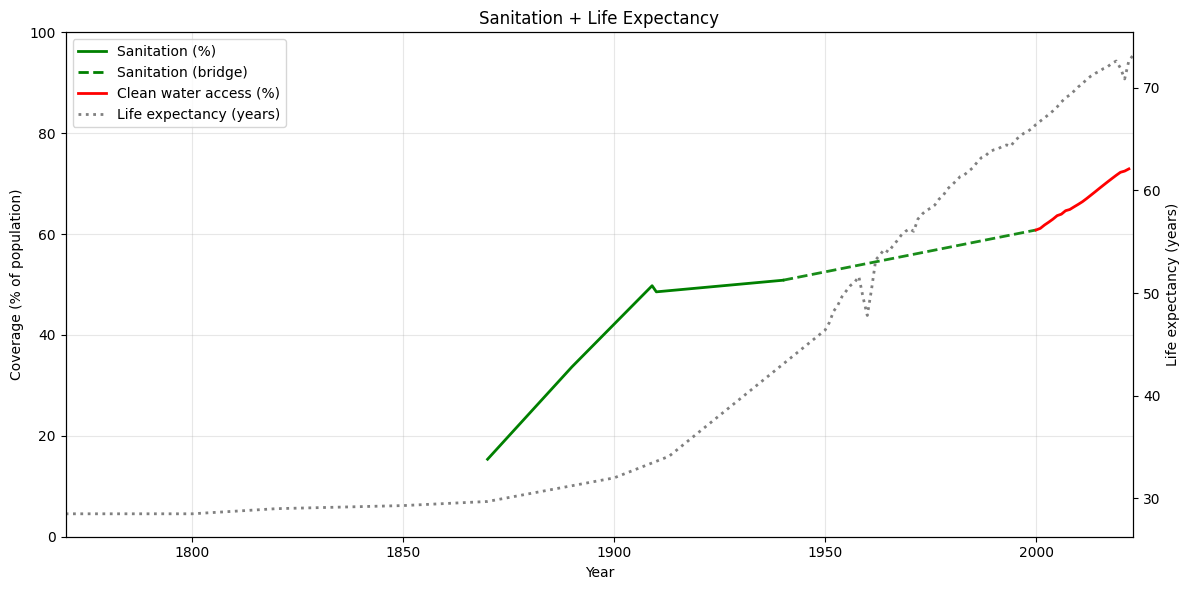

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ------- Inputs expected -------
# proxy_df: ["Year","ProxySanitation"]  (observed proxy, e.g., 1870–1940)
# world_long: World drinking water (%): ["Country Name","Year","Coverage"]
# world_life: ["Year","LifeExpectancy"]

# --- Observed sanitation points
san_obs = proxy_df[["Year","ProxySanitation"]].rename(columns={"ProxySanitation":"Sanitation"}).copy()
san_obs["Year"] = pd.to_numeric(san_obs["Year"], errors="coerce")
san_obs["Sanitation"] = pd.to_numeric(san_obs["Sanitation"], errors="coerce")
san_obs = san_obs.dropna().drop_duplicates("Year").sort_values("Year")
if san_obs.empty:
    raise ValueError("No observed sanitation points found in proxy_df.")

obs_min, obs_max = int(san_obs["Year"].min()), int(san_obs["Year"].max())

# Interpolate *within* observed sanitation span so the mid segment is smooth
san_mid_years = np.arange(obs_min, obs_max + 1)
san_mid = pd.DataFrame({"Year": san_mid_years}).merge(san_obs, on="Year", how="left")
san_mid["Sanitation"] = san_mid["Sanitation"].interpolate()

# Early (extrapolated flat) before obs_min
# (Optional: keep flat at first observed value; change if you prefer a different model)
first_val = float(san_mid.loc[san_mid["Year"] == obs_min, "Sanitation"].iloc[0])
early_years = np.arange(san_obs["Year"].min() - 1, obs_min)  # only if you want visible early extrap
san_early = pd.DataFrame({"Year": early_years, "Sanitation": first_val})

# --- Drinking water (World, %)
water = world_long.copy()
if "Country Name" in water.columns:
    water = water[water["Country Name"] == "World"]
water = water[["Year","Coverage"]].rename(columns={"Coverage":"Water"}).copy()
water["Year"] = pd.to_numeric(water["Year"], errors="coerce")
water["Water"] = pd.to_numeric(water["Water"], errors="coerce")
water = water.dropna().sort_values("Year")
water["Water"] = water["Water"].clip(0, 100)

if water.empty:
    raise ValueError("World water series is empty.")

water_min = int(water["Year"].min())
water_first_val = float(water.loc[water["Year"] == water_min, "Water"].iloc[0])

# --- Build the BRIDGE from obs_max -> water_min
# If water starts after sanitation ends, make a linear interpolation (inclusive of endpoints)
bridge = pd.DataFrame(columns=["Year","Sanitation"])
if water_min > obs_max:
    bridge_years = np.arange(obs_max, water_min + 1)
    bridge_vals = np.linspace(
        float(san_mid.loc[san_mid["Year"] == obs_max, "Sanitation"].iloc[0]),
        water_first_val,
        len(bridge_years)
    )
    bridge = pd.DataFrame({"Year": bridge_years, "Sanitation": bridge_vals})
    # We will plot sanitation up to *just before* water starts, but include bridge all the way
    # so the last bridge point equals the first water point visually.

# Clamp all sanitation-related values to [0, 100]
for df in (san_early, san_mid, bridge):
    if not df.empty:
        df["Sanitation"] = df["Sanitation"].clip(0, 100)

# --- Life expectancy (World, years)
le = world_life[["Year","LifeExpectancy"]].copy()
le["Year"] = pd.to_numeric(le["Year"], errors="coerce")
le["LifeExpectancy"] = pd.to_numeric(le["LifeExpectancy"], errors="coerce")
le = le.dropna().sort_values("Year")

# --- Plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Sanitation:
#  - early extrapolated (dashed green)
if not san_early.empty:
    ax1.plot(san_early["Year"], san_early["Sanitation"], lw=2, ls="--", color="green", alpha=0.9, label="Sanitation (extrap.)")

#  - observed/interpolated mid (solid green)
ax1.plot(san_mid["Year"], san_mid["Sanitation"], lw=2, color="green", label="Sanitation (%)")

#  - bridge segment to connect to water start (dash-dot green)
if not bridge.empty:
    # draw bridge excluding the part that overlaps deeply into water years except the last point;
    # but visually it's fine to draw the whole bridge—the red water will continue from the same point.
    ax1.plot(bridge["Year"], bridge["Sanitation"], lw=2, ls="--", color="green", alpha=0.9, label="Sanitation (bridge)")

# Water: solid red from its first year onward
ax1.plot(water["Year"], water["Water"], lw=2, color="red", label="Drinking water (%)")

ax1.set_ylim(0, 100)
xmin = int(min(san_mid["Year"].min(), water["Year"].min(), le["Year"].min()))
xmax = int(max(water["Year"].max(), le["Year"].max()))
ax1.set_xlim(xmin, xmax)
ax1.set_xlabel("Year")
ax1.set_ylabel("Coverage (% of population)")
ax1.grid(True, alpha=0.3)

# Life expectancy on the right axis (gray dotted)
ax2 = ax1.twinx()
ax2.plot(le["Year"], le["LifeExpectancy"], lw=2, ls=":", color="gray", label="Life expectancy (years)")
ax2.set_ylabel("Life expectancy (years)")

# Legend (custom so styles are clear)
handles = [
    Line2D([], [], lw=2, color="green", label="Sanitation (%)"),
    Line2D([], [], lw=2, ls="--", color="green", label="Sanitation (bridge)"),
    Line2D([], [], lw=2, color="red", label="Clean water access (%)"),
    Line2D([], [], lw=2, ls=":", color="gray", label="Life expectancy (years)"),
]
ax1.legend(handles=handles, loc="upper left")

plt.title("Sanitation + Life Expectancy")
plt.tight_layout()


# Save to PNG (best for LinkedIn upload)
fig.savefig("../data/life_expectancy_sanitation_water.png", dpi=300, bbox_inches="tight")

# Optionally, also save as SVG (scalable, great for print or editing)
fig.savefig("../data/life_expectancy_sanitation_water.svg", bbox_inches="tight")

plt.show()

# Optional: save
# fig.savefig("../data/sanitation_to_water_bridge_le.png", dpi=150, bbox_inches="tight")
